In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch the dataset from USGS GeoJSON
url = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.geojson'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to retrieve data")

# Explore the data keys
data.keys()


dict_keys(['type', 'metadata', 'features', 'bbox'])

In [2]:
# Extract earthquake features
features = data['features']

# Extract relevant data (magnitude, place, time, coordinates)
earthquakes = []
for feature in features:
    props = feature['properties']
    coords = feature['geometry']['coordinates']
    earthquakes.append([props['mag'], props['place'], props['time'], coords[0], coords[1]])

# Create a DataFrame
df = pd.DataFrame(earthquakes, columns=['Magnitude', 'Place', 'Time', 'Longitude', 'Latitude'])

# Show the first few rows of the DataFrame
df.head()


Magnitude                          Place           Time   Longitude  \
0       0.81          16 km ESE of Anza, CA  1725560865180 -116.504833   
1       1.71       16 km NNE of Olancha, CA  1725560719460 -117.921000   
2       1.14    3 km WNW of Green Acres, CA  1725560441330 -117.110667   
3       2.13       17 km NNE of Olancha, CA  1725560269350 -117.918667   
4       2.30  8 km ENE of Goldfield, Nevada  1725560240052 -117.140400   

    Latitude  
0  33.515167  
1  36.411833  
2  33.750000  
3  36.415833  
4  37.729100

/Users/jonathanyoung/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


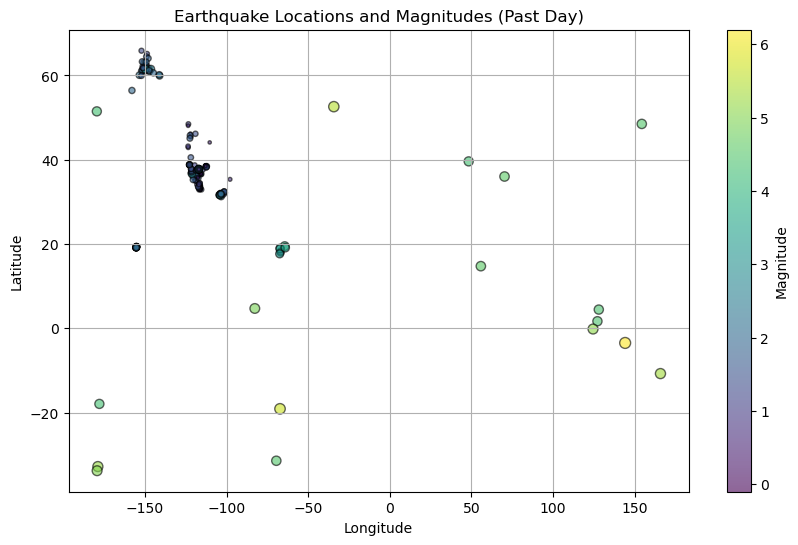

In [3]:
plt.figure(figsize=(10,6))

# Scatter plot: Longitude vs Latitude, with point sizes proportional to Magnitude
plt.scatter(df['Longitude'], df['Latitude'], s=df['Magnitude']*10, c=df['Magnitude'], cmap='viridis', alpha=0.6, edgecolor='k')

plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations and Magnitudes (Past Day)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


/var/folders/lx/4rt8gjpx3tndjbrqc3j96cr80000gp/T/ipykernel_12655/2755660201.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/jonathanyoung/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


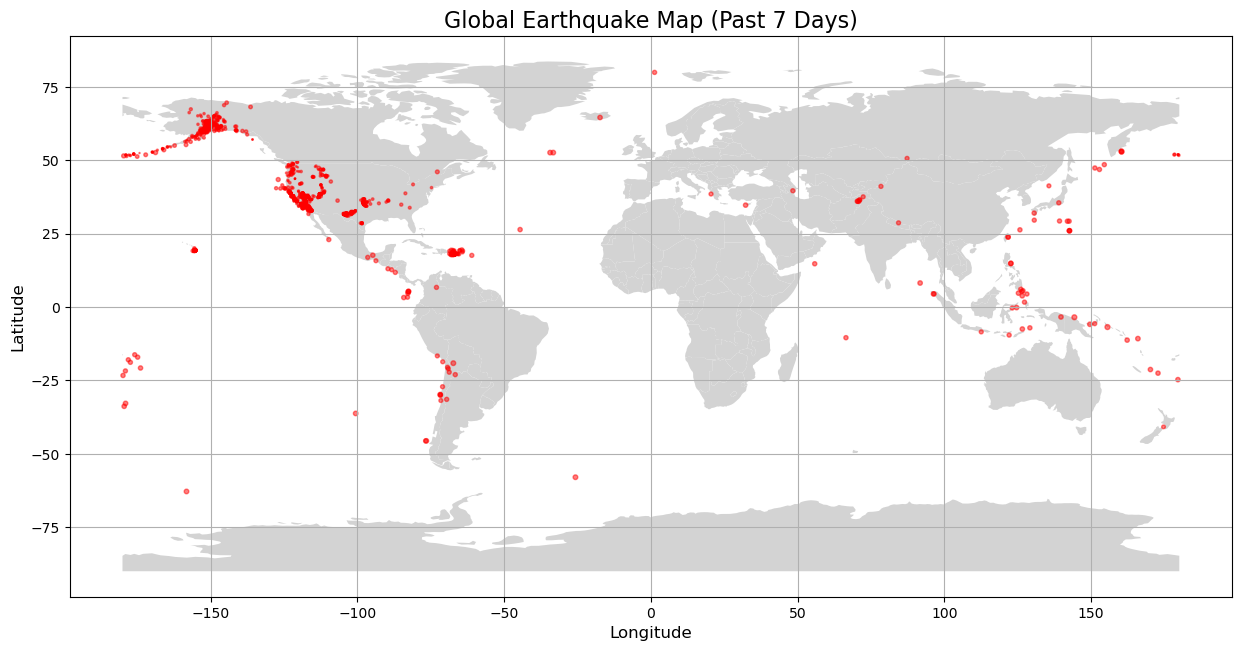

In [5]:
import geopandas as gpd

# Load world boundaries using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a GeoDataFrame for earthquake data
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the world map with earthquakes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot world boundaries
world.plot(ax=ax, color='lightgray')

# Plot earthquakes, with size and color indicating magnitude
geo_df.plot(ax=ax, markersize=df['Magnitude']*2, color='red', alpha=0.5)

# Customize plot
plt.title('Global Earthquake Map (Past 7 Days)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [7]:
# Fetch the dataset from USGS GeoJSON
url = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.geojson'
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
else:
    raise Exception(f"Failed to retrieve data. Status code: {response.status_code}")

# Extract earthquake features
features = data['features']

# Parse relevant fields (magnitude, depth, place, time, longitude, latitude)
earthquakes = []
for feature in features:
    props = feature['properties']
    coords = feature['geometry']['coordinates']
    # Append magnitude, place, depth, longitude, and latitude
    earthquakes.append([props['mag'], props['place'], props['time'], coords[0], coords[1], coords[2]])  # coords[2] is depth

# Create a DataFrame from the parsed data
df = pd.DataFrame(earthquakes, columns=['Magnitude', 'Place', 'Time', 'Longitude', 'Latitude', 'Depth'])

# Remove rows with NaN magnitudes or depths
df = df.dropna(subset=['Magnitude', 'Depth'])


In [8]:
import folium
from folium.plugins import MarkerCluster
import numpy as np

# Initialize a folium map centered at the mean latitude and longitude
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=2)

# Define a function to scale marker size based on magnitude
def get_marker_size(magnitude):
    return magnitude * 3  # Scale factor to make markers more visible

# Define a function to determine marker color based on depth
def get_marker_color(depth):
    if depth < 10:
        return 'green'
    elif depth < 50:
        return 'orange'
    else:
        return 'red'

# Add markers to the map using a MarkerCluster for better performance
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    # Create a popup with information about the earthquake
    popup_text = (f"Location: {row['Place']}<br>"
                  f"Magnitude: {row['Magnitude']}<br>"
                  f"Depth: {row['Depth']} km")
    
    # Add a circle marker to the map
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=get_marker_size(row['Magnitude']),
        color=get_marker_color(row['Depth']),
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(marker_cluster)

# Display the map
m


In [9]:
# Define the HTML for the legend
legend_html = '''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 90px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Earthquake Depth Legend <br>
     &nbsp; <i style="background:green"></i>&nbsp; Depth < 10 km<br>
     &nbsp; <i style="background:orange"></i>&nbsp; Depth 10 - 50 km<br>
     &nbsp; <i style="background:red"></i>&nbsp; Depth > 50 km<br>
     </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Show the map with the legend
m
